# **xgboost_explore_kaggle**
---

<br><br><br><br>

## Objective

- Adapt this timeseries model for intl data set to a timeseries data model for a famous Kaggle dataset
- Chosen dataset:
    - [x] avocado prices

<br><br><br>

- TODO: determine a template, boiler plate pipeline for xgboost timeseries modeling

<br><br><br>


## **Environment Setup**
---

### **Imports and Settings**

In [67]:
# imports
import numpy as np
import pandas as pd
import plotly.express as px
import lux
lux.config.default_display = 'lux'
# custom imports
from scf_data_mgmt import \
    environment, \
    visualization, \
    gbq_connection, \
    ssms_connection, \
    fcal
# Magics env settings...
# Setup sqlalchemy connection url for MSSQL Server connection here
%matplotlib inline
%load_ext google.cloud.bigquery
%load_ext sql
%env DATABASE_URL=mssql+pyodbc://SCFDW2/scfdw_core?driver=SQL+Server+Native+Client+11.0
%config SqlMagic.autocommit=True
%config SqlMagic.autopandas=True
# env setup functions
visualization.set_plotly_defaults()
from fp_data_toolbox import notifier      # win toast notifier on cell completion
notifier.setup() #Enable for windows toast notifications on Jupyter cell complete
yaml_config_path = environment.ydata_yaml_setup() #Enable to setup a ydata_profiling config.yaml file in the parent project
# env variables
gbq_project_id = 'analytics-scfinance-thd' #USER INPUT
sql_conn = 'mssql+pyodbc://SCFDW2/scfdw_core?driver=SQL+Server+Native+Client+11.0' #USER INPUT
df = pd.DataFrame()    # creating empty dataframe variable
params = {}            # creating empty parameters dictionary
# params = fcal.pull_fin_cal_temp_var()

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
The sql extension is already loaded. To reload it, use:
  %reload_ext sql
env: DATABASE_URL=mssql+pyodbc://SCFDW2/scfdw_core?driver=SQL+Server+Native+Client+11.0


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
color_pal

[(0.0, 0.5607843137254902, 0.8352941176470589),
 (0.9882352941176471, 0.30980392156862746, 0.18823529411764706),
 (0.8980392156862745, 0.6823529411764706, 0.2196078431372549),
 (0.42745098039215684, 0.5647058823529412, 0.30980392156862746),
 (0.5450980392156862, 0.5450980392156862, 0.5450980392156862),
 (0.5058823529411764, 0.058823529411764705, 0.48627450980392156)]

<br><br><br>

## **Initial Variables**

In [69]:
x_date_feature = 'DATE'
x_date_feature_index = x_date_feature + '_INDEX'
y_tgt_feature = 'TOTAL_REVENUE'

PK_LIST = [
    x_date_feature,
    'YEAR',
    'REGION',
    'TYPE',
    # 'category1',
    # 'category2',
    ]


<br><br><br>

## **Ingest Data**

In [70]:
# pull data
df = pd.read_csv('..\..\\data\\example\\avocado.csv')
# df = pd.read_csv('..\..\\data\\example\\creditcard.csv')

<br><br><br><br>

## **Clean Data**

In [71]:
### DONE: rewrite the below function for the kaggle dataset :noted_on:2023-03-23

def drop_unnecessary_features(df):
    for col in df.columns:
        if 'Unnamed: 0' in col: df = df.drop(col, axis=1) # drop columns of choice
        if 'YEAR' in col: df = df.drop(col, axis=1) # drop columns of choice
    return df

def cast_column_dtypes(
    df, 
    purpose, 
    x_date_feature, 
    y_tgt_feature,
    ):
    
    # [x] rename badly named columns here 
    df = df.rename(columns={
        "Date":             "DATE",
        ###---------------------------------
        "Total Volume":     "TOTAL_VOLUME",
        "Total Bags":       "TOTAL_BAGS",
        "Small Bags":       "SMALL_BAGS",
        "Large Bags":       "LARGE_BAGS",
        "XLarge Bags":      "XLARGE_BAGS",
        "AveragePrice":     "AVERAGE_PRICE",
        ###---------------------------------
        "type":             "TYPE",
        "region":           "REGION",
        "year":             "YEAR",
        })

    # if purpose == 'analysis':
    for col in df.columns:
        # ---------------------------------
        if x_date_feature in col:   df[col] = pd.to_datetime(df[col])
        if y_tgt_feature in col:    df[col] = pd.to_numeric(df[col], errors='coerce')
        # ---------------------------------
        if 'TYPE' in col:           df[col] = df[col].astype('category')
        if 'REGION' in col:         df[col] = df[col].astype('category')
        if 'YEAR' in col:           df[col] = df[col].astype('category')
        # ---------------------------------
        if 'AVERAGE_PRICE' in col:   df[col] = pd.to_numeric(df[col], errors='coerce')
        if 'TOTAL_VOLUME' in col:   df[col] = pd.to_numeric(df[col], errors='coerce')
        if '4046' in col:           df[col] = pd.to_numeric(df[col], errors='coerce')
        if '4225' in col:           df[col] = pd.to_numeric(df[col], errors='coerce')
        if '4770' in col:           df[col] = pd.to_numeric(df[col], errors='coerce')
        if 'TOTAL_BAGS' in col:     df[col] = pd.to_numeric(df[col], errors='coerce')
        if 'SMALL_BAGS' in col:     df[col] = pd.to_numeric(df[col], errors='coerce')
        if 'LARGE_BAGS' in col:     df[col] = pd.to_numeric(df[col], errors='coerce')
        if 'XLARGE_BAGS' in col:    df[col] = pd.to_numeric(df[col], errors='coerce')
        # ---------------------------------
    if purpose == 'ml_modeling':
        for col in df.columns:
            # ---------------------------------
            if 'YEAR' in col:   df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Create a date column if not already present
    
    df = df.sort_values(x_date_feature, ascending=True)
    
    # Set the date column as the index
    df[x_date_feature_index] = pd.to_datetime(df[x_date_feature])
    df.set_index(x_date_feature_index, inplace=True)
    if x_date_feature not in df.columns:
        df[x_date_feature] = pd.to_datetime(df.index)
    return df

def replace_category_imputation_with_null(df):
    for col in df.columns:
        if df[col].dtype.name == 'category':
            df[col] = df[col].replace([-1, 0, 'UNK', 'NULL', 'NaN'], np.nan)
    return df

def clean_measurement_columns(df):
    for col in df.columns:
        if df[col].dtype.name == 'numeric':
            df[col] = df[col].replace([-1, 0, 'UNK', 'NULL', 'NaN'], np.nan)
    return df

In [72]:
df = drop_unnecessary_features(df)

# cleaning up dtypes
df = cast_column_dtypes(
    df, 
    purpose = 'analysis',
    x_date_feature = x_date_feature, 
    y_tgt_feature = y_tgt_feature,
    )

# clean records
# df = df.query(f"{x_date_feature} < @current_dt") # cutting data off at current_dt

# bad data architecture control
df = replace_category_imputation_with_null(df)

# controlling for outliers?


In [73]:
# df.info()

In [74]:
len(df)

18249

<br><br><br>

## **Variable Declaration**

In [75]:
### DONE: declare the following variables :noted_on:2023-03-23
    # [x] x_date_feature_name
    # [x] y_tgt_feature_name
    ###---------------------------------
    # [x] pk_list = column name list of full primary key    
    ###---------------------------------
    # [x] t = 0 / current date
    # [x] train / test split date
    # [x] train_bgn_dt = minimum date from historical data
    # [x] train_end_dt = train / test split date - 1 day
    # [x] test_bgn_dt = train / test split date
    # [x] test_end_dt = current_dt - 1
    ###---------------------------------
    # [x] forecast horizon (timespan: i.e.: 3 months)
    # [x] forecast bgn_dt (current)
    # [x] forecast end_dt (current + 3 months)
    # [x] baseline bgn_dt (current - 3 months)
    # [x] baseline end_dt (current - 1 day)

In [76]:

from datetime import datetime, timedelta

current_dt_str = df[x_date_feature].max().strftime('%Y-%m-%d')
current_dt = datetime.strptime(current_dt_str, "%Y-%m-%d").date()
current_dt = pd.to_datetime(current_dt)

fcst_horizon = 365 # USER PARAMETER INPUT - # of days forward from current_dt
# [ ] unit test - validate that train_test_split_dt < (current_dt + 1 month)

baseline_bgn_dt = current_dt - timedelta(days=fcst_horizon)
baseline_end_dt = current_dt
baseline_bgn_dt = pd.to_datetime(baseline_bgn_dt)
baseline_end_dt = pd.to_datetime(baseline_end_dt)
baseline_bgn_dt_str = baseline_bgn_dt.strftime('%Y-%m-%d')
baseline_end_dt_str = baseline_end_dt.strftime('%Y-%m-%d')

fcst_bgn_dt = current_dt + timedelta(days=1)
fcst_end_dt = current_dt + timedelta(days=fcst_horizon+1)
fcst_bgn_dt = pd.to_datetime(fcst_bgn_dt)
fcst_end_dt = pd.to_datetime(fcst_end_dt)

print('current_dt = ' + current_dt.strftime('%Y-%m-%d'))
print('baseline_bgn_dt = ' + baseline_bgn_dt.strftime('%Y-%m-%d'))
print('fcst_end_dt = ' + fcst_end_dt.strftime('%Y-%m-%d'))

current_dt = 2018-03-25
baseline_bgn_dt = 2017-03-25
fcst_end_dt = 2019-03-26


In [77]:
train_test_split_dt = current_dt - timedelta(days=fcst_horizon) # USER PARAMETER INPUT - MAYBE
train_test_split_dt = pd.to_datetime(train_test_split_dt)

train_bgn_dt = df[x_date_feature].min().strftime('%Y-%m-%d') # minimum date of dataset
train_bgn_dt = pd.to_datetime(train_bgn_dt)
train_end_dt = train_test_split_dt - timedelta(days=1)
train_end_dt = pd.to_datetime(train_end_dt)
# [ ] unit test - validate that current_dt > train_bgn_dt

test_bgn_dt = train_test_split_dt
test_end_dt = current_dt - timedelta(days=1)
test_end_dt = pd.to_datetime(test_end_dt)


<br><br><br>

## **Feature Creation**

### **Measurement Features**

In [78]:
df['TOTAL_REVENUE'] = df['AVERAGE_PRICE'] * df['TOTAL_VOLUME']

### **Time Features**

In [79]:
def create_time_features(df, date_column):
    """
    This function creates various time features from a date column in a Pandas DataFrame.

    Parameters:
    df (pandas.DataFrame): A Pandas DataFrame containing a date column.
    date_column (str): The name of the date column in the DataFrame.

    Returns:
    pandas.DataFrame: A new DataFrame with various time columns cast as type integer
    """
    df['YEAR'] = df[date_column].dt.year.astype(int)
    df['QUARTER'] = df[date_column].dt.quarter.astype(int)
    df['MONTH'] = df[date_column].dt.month.astype(int)
    ###---------------------------------
    df['WEEK_OF_YEAR'] = df[date_column].dt.weekofyear.astype(int)
    df['WEEK_OF_QUARTER'] = ((df[date_column].dt.dayofyear - 1) // 7 + 1).astype(int) - 13 * (df[date_column].dt.quarter - 1)
    df['WEEK_OF_MONTH'] = ((df[date_column].dt.day - 1) // 7 + 1).astype(int)
    ###---------------------------------
    df['DAY_OF_YEAR'] = df[date_column].dt.dayofyear.astype(int)
    df['DAY_OF_QUARTER'] = ((df[date_column].dt.dayofyear - 1) // 90 + 1).astype(int)
    df['DAY_OF_MONTH'] = df[date_column].dt.day.astype(int)
    ###---------------------------------
    df['HOUR'] = df[date_column].dt.hour.astype(int)

    return df

### **Categorical Features**

In [80]:
### TODO: fill-in later :noted_on:2023-03-30

### **Creation here**

In [81]:
df = create_time_features(df, x_date_feature)

C:\Users\fxp3365\AppData\Local\Temp\1\ipykernel_29372\1452153287.py:16: FutureWarning:Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.


<br><br><br>

## **Final Data Prep**

In [82]:
# TODO reorder columns here - adhoc

<br><br><br>

## **Data Profiling (Pre-modeling)**

In [83]:
df.info()

<class 'lux.core.frame.LuxDataFrame'>
DatetimeIndex: 18249 entries, 2015-01-04 to 2018-03-25
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DATE             18249 non-null  datetime64[ns]
 1   AVERAGE_PRICE    18249 non-null  float64       
 2   TOTAL_VOLUME     18249 non-null  float64       
 3   4046             18249 non-null  float64       
 4   4225             18249 non-null  float64       
 5   4770             18249 non-null  float64       
 6   TOTAL_BAGS       18249 non-null  float64       
 7   SMALL_BAGS       18249 non-null  float64       
 8   LARGE_BAGS       18249 non-null  float64       
 9   XLARGE_BAGS      18249 non-null  float64       
 10  TYPE             18249 non-null  category      
 11  YEAR             18249 non-null  int32         
 12  REGION           18249 non-null  category      
 13  TOTAL_REVENUE    18249 non-null  float64       
 14  QUARTER          1824

In [84]:
import dtale
# dtale.instances() # run to list open instances of dtale
# dtale.get_instance(1).kill() # run to kill an instance of dtale

In [85]:
# dtale_report = dtale.show(df)
# dtale_report.open_browser()

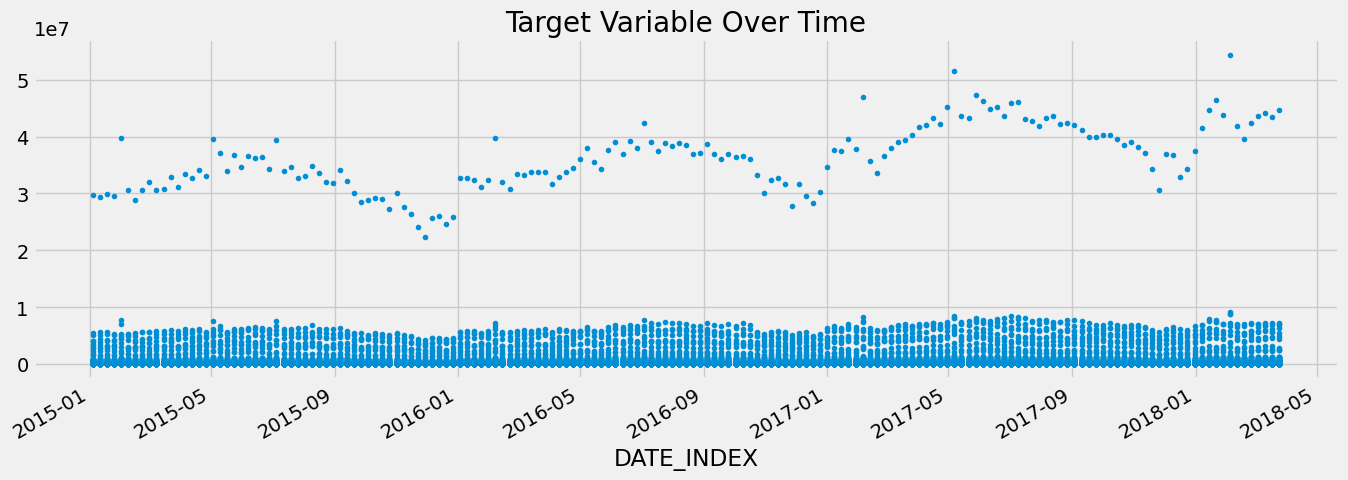

In [86]:
df[y_tgt_feature].plot(
    style = '.', 
    figsize=(15,5), 
    color=color_pal[0], 
    title = 'Target Variable Over Time',
    )
plt.show()

In [87]:
#stop

<br><br><br>

## **Pre-Training Feature Creation**

In [88]:
### DONE: FUNCTION create a variety of lag features using x_date_feature and y_tgt_feature :noted_on:2023-03-24

In [89]:
### DONE: adapt and incorporate the below function for feature creation :noted_on:2023-03-29

def create_lag_features(
    df, 
    x_date_feature, 
    measurement_column, 
    lag_period,
    num_lags, 
    aggregation_method,
    ):
    """
    Creates lag features based on input parameters.
    
    Parameters:
    dataframe (pandas.DataFrame): The input dataframe.
    measurement_column (str): The name of the column to be lagged.
    num_lags (int): The number of lag features to create.
    aggregation_method (str): The aggregation method to use (e.g. sum, mean, min, max).
    lag_period (str): The lag period length 
        (e.g. 'M' for monthly, 'W' for weekly, 'Q' for quarterly).
    
    Returns:
    pandas.DataFrame: The dataframe with the new lag features added.
    """
    
    # Resample the dataframe to the specified lag period length
    resampled_df = df[measurement_column].resample(lag_period).apply(aggregation_method)
    
    # Create lag features
    for i in range(1, num_lags + 1):
        df[f'{measurement_column}_lag_{i}{lag_period}'] = resampled_df.shift(i)
    
    # Drop rows with missing values (due to the lag)
    # new_df.dropna(inplace=True)
    
    return df

In [90]:
lag_period = 'W'    # USER INPUT
num_lags = 4        # USER INPUT
lag_measurement_column = 'TOTAL_VOLUME' # USER INPUT

In [91]:
df = create_lag_features(
    df,
    x_date_feature = x_date_feature, 
    measurement_column=lag_measurement_column,
    lag_period=lag_period,
    num_lags=num_lags, 
    aggregation_method='mean',
)

In [92]:
### TODO: FUNCTION create a variety of window features using the y_tgt_feature :noted_on:2023-03-24
    # i.e.: % of the whole on a meaningful categorical dimension
    # [ ] test1: create % of sum over partition by (month, type, region)    

In [93]:
# df.info()

<br><br><br>


## **Train / Test Split**

In [94]:
### TODO: adapt the below for the kaggle dataset :noted_on:2023-03-23

In [95]:
df_train = df.loc[df.index < train_test_split_dt]
df_test = df.loc[df.index >= train_test_split_dt]

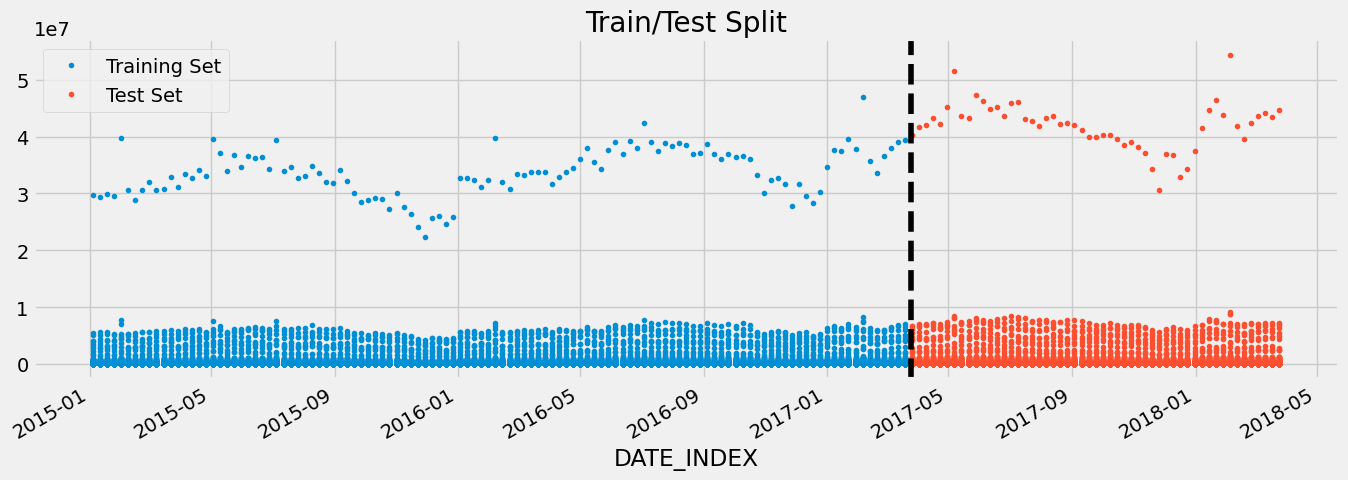

In [96]:
fig, ax = plt.subplots(figsize=(15,5))
df_train[y_tgt_feature].plot(ax=ax, style='.', label='Training Set', title='Train/Test Split')
df_test[y_tgt_feature].plot(ax=ax, style='.', label='Test Set')
ax.axvline(train_test_split_dt, color='black', ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

<br><br><br>

## **Forecasting Horizon**

- The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than 3 months) to long-term horizons (more than two years). 


<br><br><br>

## **Visualize Feature / Target Relationship**

In [97]:
# fig, ax = plt.subplots(figsize=(20, 8))

# ax.set_title = 'Target Variable by time'
# sns.boxplot(
#     data=df, 
#     x='category1', 
#     y=y_tgt_feature,
#     )

<br><br><br>

## **Prep for Model Creation**

In [98]:

# Define features for training here
    
FEATURES = [
    ###---------------------------------
    # Time features
    # x_date_feature,
    # 'time2',
    
    ###---------------------------------
    # Categorical features    
    # 'REGION',
    # 'TYPE',
    # 'category1',
    # 'category2',
    
    ###---------------------------------
    # Measurement features    
    'AVERAGE_PRICE',
    'TOTAL_VOLUME',
    '4046',
    '4225',
    '4770',
    'TOTAL_BAGS',
    'SMALL_BAGS',
    'LARGE_BAGS',
    'XLARGE_BAGS',
    
    
    ###---------------------------------
    # Lag features        
    lag_measurement_column+'_lag_'+'1'+lag_period,
    lag_measurement_column+'_lag_'+'2'+lag_period,
    lag_measurement_column+'_lag_'+'3'+lag_period,
    lag_measurement_column+'_lag_'+'4'+lag_period,
    
    
    ]

# Define target features here
TARGET = y_tgt_feature

In [99]:
df_train.info()

<class 'lux.core.frame.LuxDataFrame'>
DatetimeIndex: 12527 entries, 2015-01-04 to 2017-03-19
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE                 12527 non-null  datetime64[ns]
 1   AVERAGE_PRICE        12527 non-null  float64       
 2   TOTAL_VOLUME         12527 non-null  float64       
 3   4046                 12527 non-null  float64       
 4   4225                 12527 non-null  float64       
 5   4770                 12527 non-null  float64       
 6   TOTAL_BAGS           12527 non-null  float64       
 7   SMALL_BAGS           12527 non-null  float64       
 8   LARGE_BAGS           12527 non-null  float64       
 9   XLARGE_BAGS          12527 non-null  float64       
 10  TYPE                 12527 non-null  category      
 11  YEAR                 12527 non-null  int32         
 12  REGION               12527 non-null  category      
 13  TOTAL_REVENUE 

In [100]:
df_train = cast_column_dtypes(
    df_train, 
    purpose = 'ml_modeling',
    x_date_feature=x_date_feature,
    y_tgt_feature=y_tgt_feature,
    )
df_test = cast_column_dtypes(
    df_test, 
    purpose = 'ml_modeling',
    x_date_feature=x_date_feature,
    y_tgt_feature=y_tgt_feature,
    )

In [101]:
X_train = df_train[FEATURES]
y_train = df_train[TARGET]

X_test = df_test[FEATURES]
y_test = df_test[TARGET]

<br><br><br>


### **Hyperparameter Optimization WIP**

In [102]:
# # preprocessing for hyperparameter tuning
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)

In [103]:
# # import packages for hyperparameters tuning
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# from sklearn.metrics import accuracy_score

# #initialize the domain space for hyperparameters to be optimized
# space={
#         'n_estimators': 100,
#         'max_depth': hp.quniform('max_depth', 3, 12, 1),
#         # 'gamma': hp.uniform ('gamma', 0.2,5),
#         # 'reg_alpha' : hp.quniform('reg_alpha', 0.001, 0.1, 1),
#         # 'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         # 'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         # 'min_child_weight' : hp.quniform('min_child_weight', 1, 8, 1),
#         'seed': 0,
#     }

# def objective(space):
#     clf=xgb.XGBClassifier(
#                     n_estimators =space['n_estimators'], 
#                     max_depth = int(space['max_depth']), 
#                     # gamma = space['gamma'],
#                     # reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
#                     # colsample_bytree=int(space['colsample_bytree'])
#                     )
    
#     evaluation = [( X_train, y_train), ( X_test, y_test)]
    
#     clf.fit(X_train, y_train,
#             eval_set=evaluation, eval_metric="auc",
#             early_stopping_rounds=10,verbose=False)
    

#     pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }

In [104]:
# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

In [105]:
# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)

In [106]:
#stop

<br><br><br>


### **Train/Test Proof**

In [107]:
# Save final, optimized hyper parameters for training final model here
reg = xgb.XGBRegressor(
    booster = 'gbtree',
    objective = 'reg:squarederror',
    base_score = 0.5,
    n_estimators = 1500, # tuned
    # n_estimators = 200, # temporary
    min_child_weight = 3,
    gamma = 0,
    learning_rate = 0.048, # tuned
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth = 12,
    )


In [108]:
reg.fit(
    X_train, y_train,
    eval_set = [(X_train, y_train),(X_test,y_test)],
    verbose=100,
    )

[0]	validation_0-rmse:3354005.48253	validation_1-rmse:4192463.47588
[100]	validation_0-rmse:71281.77841	validation_1-rmse:618372.13886
[200]	validation_0-rmse:24049.71147	validation_1-rmse:540764.99643
[300]	validation_0-rmse:12332.72557	validation_1-rmse:531478.01767
[400]	validation_0-rmse:7201.02407	validation_1-rmse:529747.23695
[500]	validation_0-rmse:4182.44868	validation_1-rmse:526884.90105
[600]	validation_0-rmse:2676.48240	validation_1-rmse:526338.96882
[700]	validation_0-rmse:1763.75587	validation_1-rmse:525623.61257
[800]	validation_0-rmse:1217.55804	validation_1-rmse:525206.32679
[900]	validation_0-rmse:871.81206	validation_1-rmse:525014.68514
[1000]	validation_0-rmse:653.32170	validation_1-rmse:524971.15714
[1100]	validation_0-rmse:488.97345	validation_1-rmse:524929.03185
[1200]	validation_0-rmse:374.17156	validation_1-rmse:524915.73351
[1300]	validation_0-rmse:287.32256	validation_1-rmse:524894.03237
[1400]	validation_0-rmse:226.00649	validation_1-rmse:524885.82115
[1499]

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.048, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

**Our model is now trained** 

<br><br><br>

## **Feature Importance**

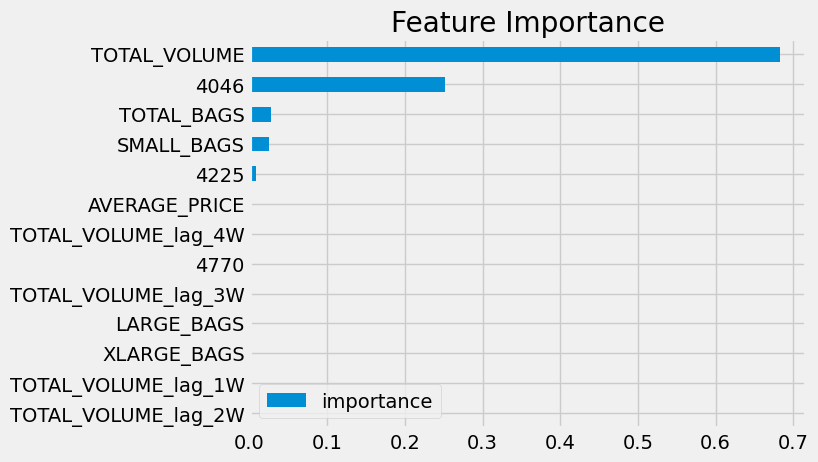

In [109]:
df_fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance']
)
df_fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

<br><br><br>

## **Test forecast on the test set**

In [110]:
df_test[f'{y_tgt_feature}_PREDICTION'] = reg.predict(X_test)

# df_test[f'{y_tgt_feature}_PREDICTION'] = df_test[f'{y_tgt_feature}_PREDICTION'].apply(lambda x: 0 if x < 0 else x) # controlling for negative predictions

join_cols_list = PK_LIST[:]
join_cols_list.extend([f'{y_tgt_feature}_PREDICTION'])

print(PK_LIST)
print(join_cols_list)

['DATE', 'YEAR', 'REGION', 'TYPE']
['DATE', 'YEAR', 'REGION', 'TYPE', 'TOTAL_REVENUE_PREDICTION']


In [111]:
df_test = df_test[join_cols_list]
df_test = df_test.sort_values(x_date_feature, ascending=True)

In [112]:
df_test = pd.merge(
    df,
    df_test,
    how='left', 
    on=PK_LIST,
    )
df_test = cast_column_dtypes(
    df_test, 
    purpose='analysis',
    x_date_feature = x_date_feature,
    y_tgt_feature = y_tgt_feature,
    )

In [113]:
print(df_test.columns)

Index(['DATE', 'AVERAGE_PRICE', 'TOTAL_VOLUME', '4046', '4225', '4770',
       'TOTAL_BAGS', 'SMALL_BAGS', 'LARGE_BAGS', 'XLARGE_BAGS', 'TYPE', 'YEAR',
       'REGION', 'TOTAL_REVENUE', 'QUARTER', 'MONTH', 'WEEK_OF_YEAR',
       'WEEK_OF_QUARTER', 'WEEK_OF_MONTH', 'DAY_OF_YEAR', 'DAY_OF_QUARTER',
       'DAY_OF_MONTH', 'HOUR', 'TOTAL_VOLUME_lag_1W', 'TOTAL_VOLUME_lag_2W',
       'TOTAL_VOLUME_lag_3W', 'TOTAL_VOLUME_lag_4W',
       'TOTAL_REVENUE_PREDICTION'],
      dtype='object')


In [114]:
#stop

<br><br><br>

## **Measure Model Performance**

<br>

### **Calculate root mean squared error**

In [115]:
df_test = df_test.loc[df_test['DATE'] >= train_test_split_dt]
score = np.sqrt(mean_squared_error(df_test[y_tgt_feature], df_test[f'{y_tgt_feature}_PREDICTION']))
stdev = df_test[y_tgt_feature].std()
normalized_score = score / stdev
print(f'RMSE Score on Test set: {score:0.6f}')
print(f'RMSE / StdDev on Test set: {normalized_score:0.6f}')

RMSE Score on Test set: 524883.751035
RMSE / StdDev on Test set: 0.124310


<br>

### **Calculate Nominal Error**

- Look at the worst and best predicted weeks

In [116]:
df_test['abs_error'] = np.abs(df_test[TARGET] - df_test[f'{y_tgt_feature}_PREDICTION'])
df_test['error'] = df_test[TARGET] - df_test[f'{y_tgt_feature}_PREDICTION']

<br>

### **Visualize Test over Train**

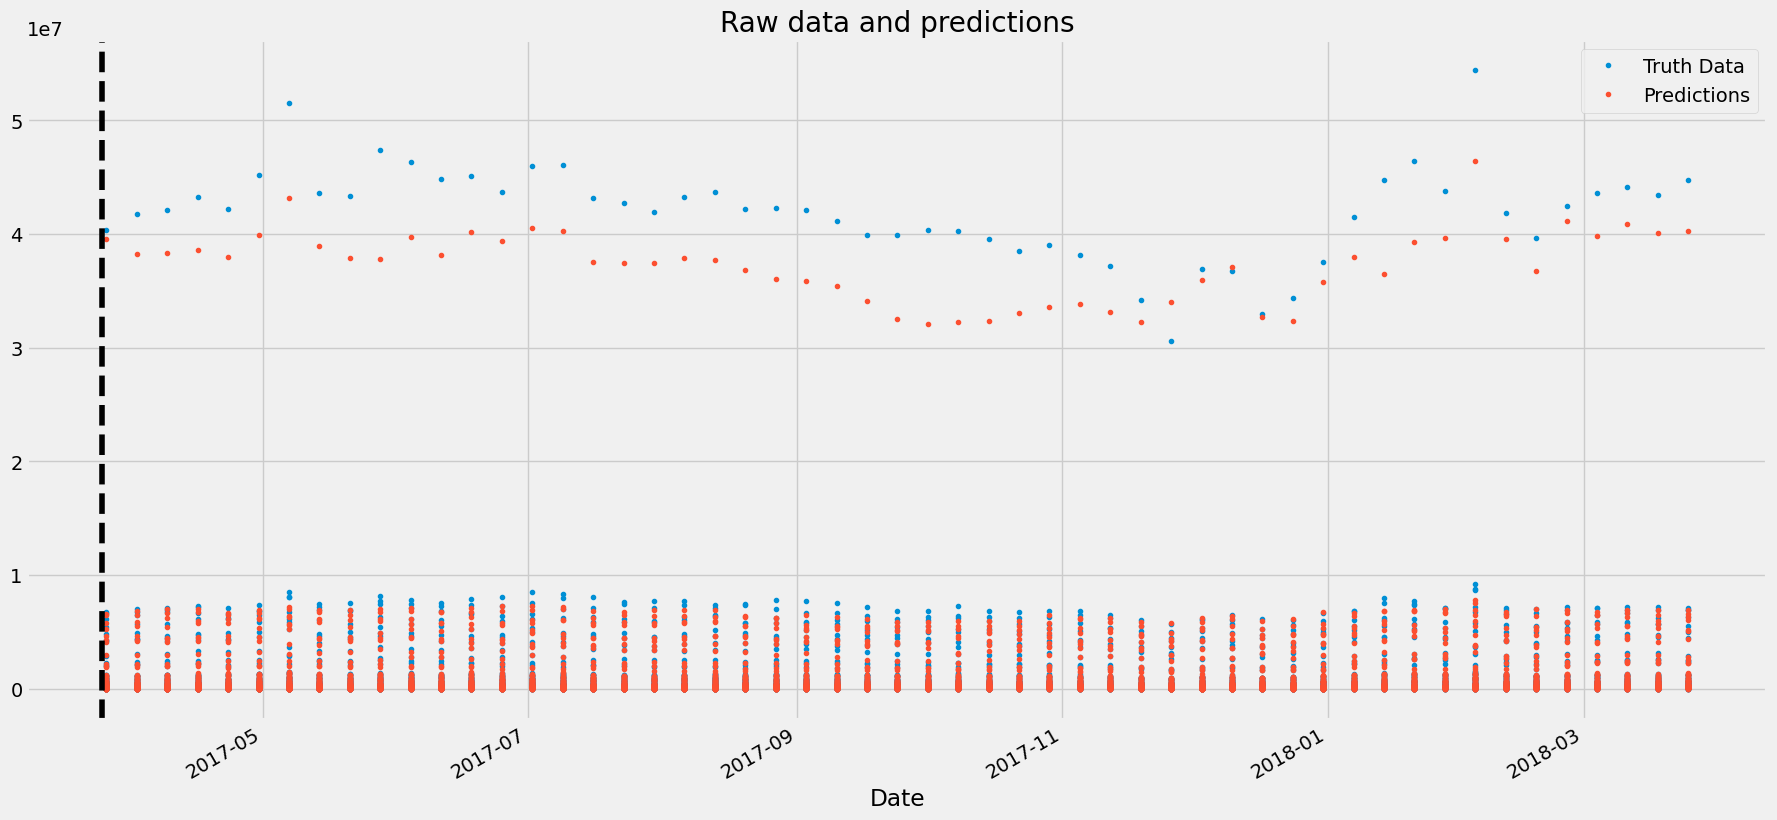

In [117]:
ax = df_test[[y_tgt_feature]].plot(figsize=(20,10), style='.')
df_test[f'{y_tgt_feature}_PREDICTION'].plot(
    ax=ax, 
    style='.',
    )
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw data and predictions')
ax.set_xlabel('Date')
ax.axvline(train_test_split_dt, color='black', ls='--')
plt.show()

In [118]:
# df_test.to_clipboard(excel=True, index=False, header=True)

In [119]:
#stop

<br><br><br><br><br><br>

## **Predicting into the future**

- Retraining on all data

In [120]:
# Define features for training here
df_train = cast_column_dtypes(
    df, 
    purpose='ml_modeling',
    x_date_feature = x_date_feature, 
    y_tgt_feature = y_tgt_feature,
    )
x_all = df_train[FEATURES]
y_all = df_train[TARGET]

In [121]:

reg = xgb.XGBRegressor(
    booster = 'gbtree',
    # objective = 'reg:linear',
    objective = 'reg:squarederror',
    base_score = 0.5,
    n_estimators = 1500, # tuned
    # n_estimators = 200, # temp
    learning_rate = 0.042, # tuned
    # learning_rate = 0.042,
    max_depth = 12, # tuned
    # max_depth = 6,
    )
reg.fit(
    x_all, 
    y_all,
    eval_set = [(x_all, y_all)],
    verbose = 100,
    )

[0]	validation_0-rmse:3645370.26034
[100]	validation_0-rmse:82651.54825
[200]	validation_0-rmse:6787.67298
[300]	validation_0-rmse:1863.93130
[400]	validation_0-rmse:1250.46049
[500]	validation_0-rmse:903.92693
[600]	validation_0-rmse:673.98688
[700]	validation_0-rmse:495.54004
[800]	validation_0-rmse:373.82813
[900]	validation_0-rmse:281.47227
[1000]	validation_0-rmse:222.48424
[1100]	validation_0-rmse:181.97084
[1200]	validation_0-rmse:147.17153
[1300]	validation_0-rmse:128.08073
[1400]	validation_0-rmse:117.79278
[1499]	validation_0-rmse:114.63510


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.042, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<br><br><br>

### **Create future data structure**

In [122]:
# query the dataframe to only include dates within the specified range
df_fcst = df.query(f"('{baseline_bgn_dt_str}' <= {x_date_feature}) & ({x_date_feature} <= '{baseline_end_dt_str}')")

In [123]:
df_fcst[x_date_feature] = df_fcst[x_date_feature].apply(lambda x: x + timedelta(days=fcst_horizon))

c:\Users\fxp3365\_github-repos\personal-projects\scf_data_mgmt-proj\.venv\lib\site-packages\lux\core\frame.py:193: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [124]:
min_dt = df_fcst[x_date_feature].min().strftime('%Y-%m-%d')
max_dt = df_fcst[x_date_feature].max().strftime('%Y-%m-%d')
print(min_dt)
print(max_dt)

2018-03-26
2019-03-25


In [125]:
# df_fcst.to_clipboard(excel=True, index=False, header=True)

<br><br><br>

### **Predict the future**

In [126]:
df_fcst = cast_column_dtypes(
        df_fcst, 
        purpose='ml_modeling',
        x_date_feature=x_date_feature,
        y_tgt_feature=y_tgt_feature,
        )
df_fcst[f'{y_tgt_feature}_PREDICTION'] = reg.predict(df_fcst[FEATURES])

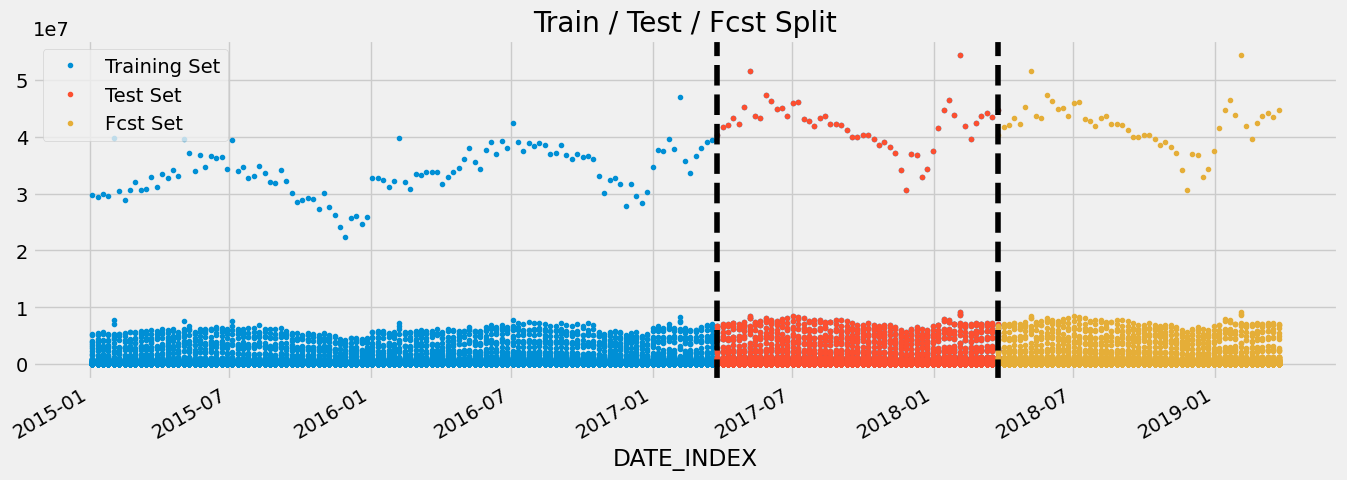

In [127]:
fig, ax = plt.subplots(figsize=(15,5))
df_train[y_tgt_feature].plot(ax=ax, style='.', label='Training Set', title='Train / Test / Fcst Split')
df_test[y_tgt_feature].plot(ax=ax, style='.', label='Test Set')
df_fcst[y_tgt_feature].plot(ax=ax, style='.', label='Fcst Set')
ax.axvline(train_test_split_dt, color='black', ls='--')
ax.axvline(fcst_bgn_dt, color='black', ls='--')
ax.legend(['Training Set','Test Set','Fcst Set'])
plt.show()

In [128]:
# df_fcst.to_clipboard(excel=True, index=False, header=True)

<br><br><br>

## **Saving Model for Later**

In [129]:
reg.save_model(f'xgb_model-{y_tgt_feature}.json')

<br><br><br>

### **Loading it back up for validation**

In [130]:
reg_new = xgb.XGBRegressor()
reg_new.load_model(f'xgb_model-{y_tgt_feature}.json')
# predict the future
df_fcst[f'{y_tgt_feature}_PREDICTION'] = reg.predict(df_fcst[FEATURES])

<br>

### **Plot the future**

<AxesSubplot: title={'center': 'Future Predictions'}, xlabel='DATE_INDEX'>

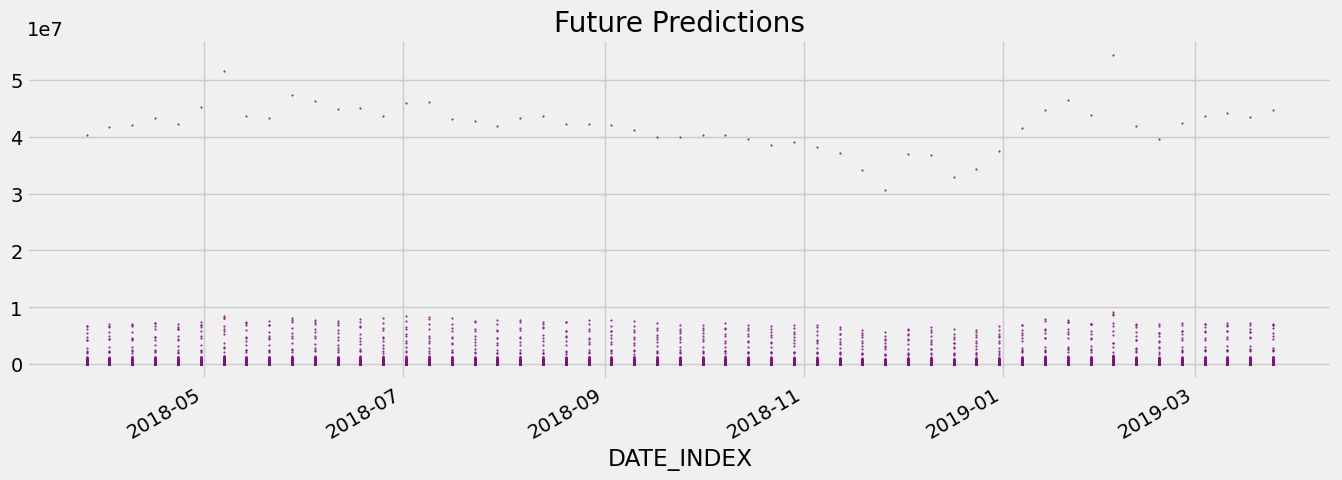

In [131]:
#plot the future
df_fcst[f'{y_tgt_feature}_PREDICTION'].plot(
    figsize=(15, 5),
    style='.',
    color=color_pal[5],
    ms=1,
    lw=1, title='Future Predictions'
)

In [132]:
# df_fcst.to_clipboard(excel=True, index=False, header=True)

In [ ]:
#stop